## Content  
1. [Separate variants by pathogenicity value](#1.-Separate-variants-by-pathogenicity-value)
2. [Balance dataframes](#2.-Balance-dataframes)
3. [Visualize the distribution of cDNA positions relative to the transcripts boundaries](#3.-Visualize-the-distribution-of-cDNA-positions-relative-to-the-transcripts-boundaries)
4. [Get sequence context](#4.-Get-sequence-context)
5. [Build a sequence logo](#5.-Build-a-sequence-logo)
6. [Statistical comparison of positions in contexts](#6.-Statistical-comparison-of-positions-in-contexts)

In [1]:
import datetime
import json
from os.path import join

import logomaker as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyliftover
import seaborn as sns
import seqlogo
from Bio.Seq import Seq
from pyfaidx import Fasta

from all_code import (
                        get_cdna_percentage,
                        calculate_chi2_p_values,
                        filter_and_convert_to_list,
                        get_context,
                        plot_p_values,
                        translate_context,
                    )

## 1. Separate variants by pathogenicity value

Create dataframes for pathogenic/benign variants based on frequency.

* **pathogenic**  
 Cutoff in AC < 2. Additionally, intersect with the options in ClinVar and add pathogenic/likely pathogenic variants that are missing in GnomAD v.4, but are in ClinVar.

* **benign**  
 AC cut-off >= 2 (according to recent ACGS guidelines, BS2 criterion). In this case, we may have many autosomal recessive variants left, so let’s remove them. To do this, compare the resulting dataframe with benign ClinVar variants and remove all intersections with registered P/LP variants.

ClinVar does not contain transcripts for the variants, so first annotate the downloaded Clinvar file (GRCh38 version) with VEP. 

In [2]:
nmd_undergo_df = pd.read_csv("data/nmd_undergo_df.csv")

In [3]:
pat_nmd_undergo = nmd_undergo_df.query('AC < 2')

In [4]:
ben_nmd_undergo = nmd_undergo_df.query('AC >= 2')

### Remove all pathogenic Clinvar variants from benign dataframe

Merge `clinvar_nmd_undergo_df` and `ben_nmd_undergo` dataframes, remove all intersections by `CHROM`, `POS`, `REF`, `ALT`, and then remove the remainder of `clinvar_nmd_undergo_df` (i.e. remove all rows that do not have an empty `CLNSIG` column).

In [5]:
clinvar_nmd_undergo_df = pd.read_csv("data/clinvar_nmd_undergo_df.csv")
clinvar_nmd_undergo = clinvar_nmd_undergo_df.rename(columns={'Feature': 'Canonical_transcript'})

In [6]:
merged_clinvar_and_ben_undergo = pd.concat([ben_nmd_undergo, clinvar_nmd_undergo], ignore_index=True)
merged_clinvar_and_ben_undergo

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2025660,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2028164,rs1441225021,C,G,HIGH,stop_gained,GABRD,ENST00000378585,642,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,2029236,rs1405824159,C,T,HIGH,stop_gained,GABRD,ENST00000378585,896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,2228818,rs1225111926,C,T,HIGH,stop_gained,SKI,ENST00000378536,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,2511342,.,A,C,HIGH,stop_gained,PANK4,ENST00000378466,1838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8899,chr22,50721740,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,3958,...,545051.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8900,chr22,50722004,NaN,G,T,NaN,stop_gained,NaN,ENST00000262795,4222,...,2663911.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8901,chr22,50722235,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,4453,...,422407.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8902,chr22,50722255,NaN,G,A,NaN,stop_gained,NaN,ENST00000262795,4473,...,1675899.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES


In [7]:
# remove duplicates
ben_nmd_undergo_filtered = merged_clinvar_and_ben_undergo.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep=False)
ben_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2025660,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2028164,rs1441225021,C,G,HIGH,stop_gained,GABRD,ENST00000378585,642,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,2029236,rs1405824159,C,T,HIGH,stop_gained,GABRD,ENST00000378585,896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,2228818,rs1225111926,C,T,HIGH,stop_gained,SKI,ENST00000378536,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,2511342,.,A,C,HIGH,stop_gained,PANK4,ENST00000378466,1838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8899,chr22,50721740,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,3958,...,545051.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8900,chr22,50722004,NaN,G,T,NaN,stop_gained,NaN,ENST00000262795,4222,...,2663911.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8901,chr22,50722235,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,4453,...,422407.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8902,chr22,50722255,NaN,G,A,NaN,stop_gained,NaN,ENST00000262795,4473,...,1675899.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES


In [8]:
# remove the Clinvar df
ben_nmd_undergo_filtered = ben_nmd_undergo_filtered[~ben_nmd_undergo_filtered['CLNSIG'].notna()]
ben_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2025660,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2028164,rs1441225021,C,G,HIGH,stop_gained,GABRD,ENST00000378585,642,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,2029236,rs1405824159,C,T,HIGH,stop_gained,GABRD,ENST00000378585,896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,2228818,rs1225111926,C,T,HIGH,stop_gained,SKI,ENST00000378536,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,2511342,.,A,C,HIGH,stop_gained,PANK4,ENST00000378466,1838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473,chr22,50600868,.,C,A,HIGH,stop_gained,MAPK8IP2,ENST00000329492,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3474,chr22,50720238,.,C,A,HIGH,stop_gained,SHANK3,ENST00000262795,2456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3475,chr22,50720534,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,2752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3476,chr22,50721521,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,3739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
ben_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape', 'ID',
       'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 'Gene', 'Feature_type',
       'BIOTYPE', 'CANONICAL'],
      dtype='object')

Remove unnecessary columns left after Clinvar.

In [10]:
ben_nmd_undergo_filtered = ben_nmd_undergo_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 
                                                'Gene', 'Feature_type', 'BIOTYPE', 'CANONICAL'])
ben_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
0,chr1,2025660,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,471,HC,NaN,NaN,2.0,0.245,1.000000,NO
1,chr1,2028164,rs1441225021,C,G,HIGH,stop_gained,GABRD,ENST00000378585,642,HC,NaN,NaN,3.0,0.245,1.000000,NO
2,chr1,2029236,rs1405824159,C,T,HIGH,stop_gained,GABRD,ENST00000378585,896,HC,NaN,NaN,5.0,0.245,1.000000,NO
3,chr1,2228818,rs1225111926,C,T,HIGH,stop_gained,SKI,ENST00000378536,500,HC,NaN,NaN,2.0,0.194,0.950938,NO
4,chr1,2511342,.,A,C,HIGH,stop_gained,PANK4,ENST00000378466,1838,HC,NaN,NaN,2.0,0.304,0.694764,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473,chr22,50600868,.,C,A,HIGH,stop_gained,MAPK8IP2,ENST00000329492,76,HC,NaN,NaN,2.0,0.100,0.775794,NO
3474,chr22,50720238,.,C,A,HIGH,stop_gained,SHANK3,ENST00000262795,2456,HC,NaN,NaN,3.0,0.123,1.000000,NO
3475,chr22,50720534,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,2752,HC,NaN,NaN,2.0,0.123,1.000000,NO
3476,chr22,50721521,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,3739,HC,NaN,NaN,5.0,0.123,1.000000,NO


Before filtering:

In [11]:
ben_nmd_undergo.shape

(3478, 17)

Add position in codon for each variant.

In [12]:
ben_nmd_undergo_filtered['cDNA_position'] = ben_nmd_undergo_filtered['cDNA_position'].astype(int)

ben_nmd_undergo_filtered['Codon_position'] = np.where(ben_nmd_undergo_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(ben_nmd_undergo_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

ben_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position
0,chr1,2025660,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,471,HC,NaN,NaN,2.0,0.245,1.000000,NO,3
1,chr1,2028164,rs1441225021,C,G,HIGH,stop_gained,GABRD,ENST00000378585,642,HC,NaN,NaN,3.0,0.245,1.000000,NO,3
2,chr1,2029236,rs1405824159,C,T,HIGH,stop_gained,GABRD,ENST00000378585,896,HC,NaN,NaN,5.0,0.245,1.000000,NO,2
3,chr1,2228818,rs1225111926,C,T,HIGH,stop_gained,SKI,ENST00000378536,500,HC,NaN,NaN,2.0,0.194,0.950938,NO,2
4,chr1,2511342,.,A,C,HIGH,stop_gained,PANK4,ENST00000378466,1838,HC,NaN,NaN,2.0,0.304,0.694764,NO,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473,chr22,50600868,.,C,A,HIGH,stop_gained,MAPK8IP2,ENST00000329492,76,HC,NaN,NaN,2.0,0.100,0.775794,NO,1
3474,chr22,50720238,.,C,A,HIGH,stop_gained,SHANK3,ENST00000262795,2456,HC,NaN,NaN,3.0,0.123,1.000000,NO,2
3475,chr22,50720534,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,2752,HC,NaN,NaN,2.0,0.123,1.000000,NO,1
3476,chr22,50721521,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,3739,HC,NaN,NaN,5.0,0.123,1.000000,NO,1


**The dataframe with benign variants is ready.**

### Add all non-population pathogenic Clinvar variants to the pathogenic dataframe

Now add to `pat_nmd_undergo` variants that are P/LP according to ClinVar and are not found in the GnomAD v4 database.

In [13]:
pat_nmd_undergo.shape[0] + clinvar_nmd_undergo.shape[0]

15827

In [14]:
merged_clinvar_and_pat = pat_nmd_undergo.merge(clinvar_nmd_undergo, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', indicator=True)
merged_clinvar_and_pat

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge
0,chr1,1790454,NaN,G,A,NaN,NaN,NaN,NaN,NaN,...,ENSG00000078369,Transcript,ENST00000378609,protein_coding,1003.0,YES,0.145,0.951698,NO,right_only
1,chr1,1825438,rs867938404,G,A,HIGH,stop_gained,GNB1,ENST00000378609,379.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,2024966,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,172.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,2024966,.,C,G,HIGH,stop_gained,GABRD,ENST00000378585,172.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,2024993,.,G,A,HIGH,stop_gained,GABRD,ENST00000378585,199.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15489,chr9,138120696,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,ENSG00000148408,Transcript,ENST00000371372,protein_coding,6456.0,YES,0.240,0.976450,NO,right_only
15490,chr9,138120738,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6498.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
15491,chr9,138120765,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6525.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
15492,chr9,138120776,.,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6536.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [15]:
pat_nmd_undergo_filtered = merged_clinvar_and_pat.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep='first', ignore_index=True)

In [16]:
duplicates = pat_nmd_undergo_filtered[pat_nmd_undergo_filtered.duplicated(subset=['CHROM', 'POS', 'ALT'], keep=False)]
duplicates

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge


In [17]:
pat_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 'SYMBOL',
       'Gene', 'Feature_type', 'Canonical_transcript_y', 'BIOTYPE',
       'cDNA_position_y', 'CANONICAL', 'LOEUF_y', 'pext_y', 'NMD_escape_y',
       '_merge'],
      dtype='object')

In [18]:
pat_nmd_undergo_filtered['Canonical_transcript_x'] = pat_nmd_undergo_filtered['Canonical_transcript_x'].fillna(pat_nmd_undergo_filtered['Canonical_transcript_y'])
pat_nmd_undergo_filtered['cDNA_position_x'] = pat_nmd_undergo_filtered['cDNA_position_x'].fillna(pat_nmd_undergo_filtered['cDNA_position_y'])
pat_nmd_undergo_filtered['Consequence_x'] = pat_nmd_undergo_filtered['Consequence_x'].fillna(pat_nmd_undergo_filtered['Consequence_y'])
pat_nmd_undergo_filtered['LOEUF_x'] = pat_nmd_undergo_filtered['LOEUF_x'].fillna(pat_nmd_undergo_filtered['LOEUF_y'])
pat_nmd_undergo_filtered['Gene_symbol'] = pat_nmd_undergo_filtered['Gene_symbol'].fillna(pat_nmd_undergo_filtered['SYMBOL'])
pat_nmd_undergo_filtered['NMD_escape_x'] = pat_nmd_undergo_filtered['NMD_escape_x'].fillna(pat_nmd_undergo_filtered['NMD_escape_y'])
pat_nmd_undergo_filtered['pext_x'] = pat_nmd_undergo_filtered['pext_x'].fillna(pat_nmd_undergo_filtered['pext_y'])

In [19]:
pat_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 'SYMBOL',
       'Gene', 'Feature_type', 'Canonical_transcript_y', 'BIOTYPE',
       'cDNA_position_y', 'CANONICAL', 'LOEUF_y', 'pext_y', 'NMD_escape_y',
       '_merge'],
      dtype='object')

In [20]:
pat_nmd_undergo_filtered = pat_nmd_undergo_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 
                                                'SYMBOL', 'Gene', 'Feature_type', 'Canonical_transcript_y', 
                                                'BIOTYPE', 'cDNA_position_y', 'CANONICAL', '_merge', 'LOEUF_y', 'NMD_escape_y', 'pext_y'])

pat_nmd_undergo_filtered = pat_nmd_undergo_filtered.rename(columns={'cDNA_position_x': 'cDNA_position', 
                                                  'Canonical_transcript_x': 'Canonical_transcript', 
                                                  'Consequence_x': 'Consequence', 'LOEUF_x': 'LOEUF', 
                                                  'NMD_escape_x':'NMD_escape', 'pext_x': 'pext'})
pat_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
0,chr1,1790454,NaN,G,A,NaN,stop_gained,GNB1,ENST00000378609,1003.0,NaN,NaN,NaN,NaN,0.145,0.951698,NO
1,chr1,1825438,rs867938404,G,A,HIGH,stop_gained,GNB1,ENST00000378609,379.0,HC,NaN,NaN,1.0,0.145,0.966547,NO
2,chr1,2024966,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,172.0,HC,NaN,NaN,1.0,0.245,1.000000,NO
3,chr1,2024966,.,C,G,HIGH,stop_gained,GABRD,ENST00000378585,172.0,HC,NaN,NaN,1.0,0.245,1.000000,NO
4,chr1,2024993,.,G,A,HIGH,stop_gained,GABRD,ENST00000378585,199.0,HC,NaN,NaN,1.0,0.245,1.000000,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15489,chr9,138120696,NaN,C,T,NaN,stop_gained,CACNA1B,ENST00000371372,6456.0,NaN,NaN,NaN,NaN,0.240,0.976450,NO
15490,chr9,138120738,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6498.0,HC,NaN,NaN,1.0,0.240,0.976450,NO
15491,chr9,138120765,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6525.0,HC,NaN,NaN,1.0,0.240,0.976450,NO
15492,chr9,138120776,.,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6536.0,HC,NaN,NaN,1.0,0.240,0.976450,NO


In [21]:
pat_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape'],
      dtype='object')

Before adding Clinvar variants:

In [22]:
pat_nmd_undergo.shape

(10401, 17)

Add position in codon for each variant.

In [23]:
pat_nmd_undergo_filtered['cDNA_position'] = pat_nmd_undergo_filtered['cDNA_position'].astype(int)

pat_nmd_undergo_filtered['Codon_position'] = np.where(pat_nmd_undergo_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(pat_nmd_undergo_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

pat_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position
0,chr1,1790454,NaN,G,A,NaN,stop_gained,GNB1,ENST00000378609,1003,NaN,NaN,NaN,NaN,0.145,0.951698,NO,1
1,chr1,1825438,rs867938404,G,A,HIGH,stop_gained,GNB1,ENST00000378609,379,HC,NaN,NaN,1.0,0.145,0.966547,NO,1
2,chr1,2024966,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,172,HC,NaN,NaN,1.0,0.245,1.000000,NO,1
3,chr1,2024966,.,C,G,HIGH,stop_gained,GABRD,ENST00000378585,172,HC,NaN,NaN,1.0,0.245,1.000000,NO,1
4,chr1,2024993,.,G,A,HIGH,stop_gained,GABRD,ENST00000378585,199,HC,NaN,NaN,1.0,0.245,1.000000,NO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15489,chr9,138120696,NaN,C,T,NaN,stop_gained,CACNA1B,ENST00000371372,6456,NaN,NaN,NaN,NaN,0.240,0.976450,NO,3
15490,chr9,138120738,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6498,HC,NaN,NaN,1.0,0.240,0.976450,NO,3
15491,chr9,138120765,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6525,HC,NaN,NaN,1.0,0.240,0.976450,NO,3
15492,chr9,138120776,.,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6536,HC,NaN,NaN,1.0,0.240,0.976450,NO,2


**The dataframe with pathogenic variants is ready.**

## 2. Balance dataframes

In both dataframes, we will leave only those genes that are found in both `ben_nmd_undergo_filtered` and `pat_nmd_undergo_filtered`, and also equalize the number of variants in each gene.

In [24]:
unique_genes_ben = ben_nmd_undergo_filtered['Gene_symbol'].unique()
unique_genes_pat = pat_nmd_undergo_filtered['Gene_symbol'].unique()
intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Unique genes in pat dataframe:", len(unique_genes_pat))
print("Unique genes in ben dataframe:", len(unique_genes_ben))
print("Intersected genes:", len(intersected_genes))


Unique genes in pat dataframe: 1415
Unique genes in ben dataframe: 917
Intersected genes: 900


In [25]:
common_genes = set(unique_genes_ben) & set(unique_genes_pat)

ben_nmd_undergo_filtered = ben_nmd_undergo_filtered[ben_nmd_undergo_filtered['Gene_symbol'].isin(common_genes)]
pat_nmd_undergo_filtered = pat_nmd_undergo_filtered[pat_nmd_undergo_filtered['Gene_symbol'].isin(common_genes)]

In [26]:
unique_genes_pat = pat_nmd_undergo_filtered['Gene_symbol'].unique()
unique_genes_ben = ben_nmd_undergo_filtered['Gene_symbol'].unique()

intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Unique genes in pat dataframe:", len(unique_genes_pat))
print("Unique genes in ben dataframe:", len(unique_genes_ben))
print("Intersected genes:", len(intersected_genes))

Unique genes in pat dataframe: 900
Unique genes in ben dataframe: 900
Intersected genes: 900


In [27]:
count_pat = pat_nmd_undergo_filtered['Gene_symbol'].value_counts()
count_ben = ben_nmd_undergo_filtered['Gene_symbol'].value_counts()

min_counts = pd.concat([count_pat, count_ben], axis=1).min(axis=1)

pat_nmd_undergo_final = pd.concat([
    pat_nmd_undergo_filtered[pat_nmd_undergo_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])

ben_nmd_undergo_final = pd.concat([
    ben_nmd_undergo_filtered[ben_nmd_undergo_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])


In [28]:
pat_nmd_undergo_final.shape == ben_nmd_undergo_final.shape

True

In [29]:
pat_nmd_undergo_final['Gene_symbol'].nunique() == ben_nmd_undergo_final['Gene_symbol'].nunique()

True

In [30]:
pat_nmd_undergo_final['Gene_symbol'].value_counts().sum() == ben_nmd_undergo_final['Gene_symbol'].value_counts().sum()

True

In [31]:
pat_nmd_undergo_final['Gene_symbol'].nunique()

900

Dataframes are now balanced by genes and number of variants.

## 3. Visualize the distribution of cDNA positions relative to the transcripts boundaries

Get a dictionary with transcript lengths and write the % location of the variant into a dataframe.

In [32]:
pat_nmd_undergo_final['Percent_position'] = pat_nmd_undergo_final.apply(get_cdna_percentage, axis=1)
ben_nmd_undergo_final['Percent_position'] = ben_nmd_undergo_final.apply(get_cdna_percentage, axis=1)

Visualize the distribution of variants.

In [33]:
pat_nmd_undergo_final_sorted = pat_nmd_undergo_final.copy()
pat_nmd_undergo_final_sorted['CHROM'] = pat_nmd_undergo_final_sorted['CHROM'].str.extract(r'(\d+)')
pat_nmd_undergo_final_sorted = pat_nmd_undergo_final_sorted.sort_values(by='CHROM', key=lambda x: x.astype(int))

In [34]:
ben_nmd_undergo_final_sorted = ben_nmd_undergo_final.copy()
ben_nmd_undergo_final_sorted['CHROM'] = ben_nmd_undergo_final_sorted['CHROM'].str.extract(r'(\d+)')
ben_nmd_undergo_final_sorted = ben_nmd_undergo_final_sorted.sort_values(by='CHROM', key=lambda x: x.astype(int))

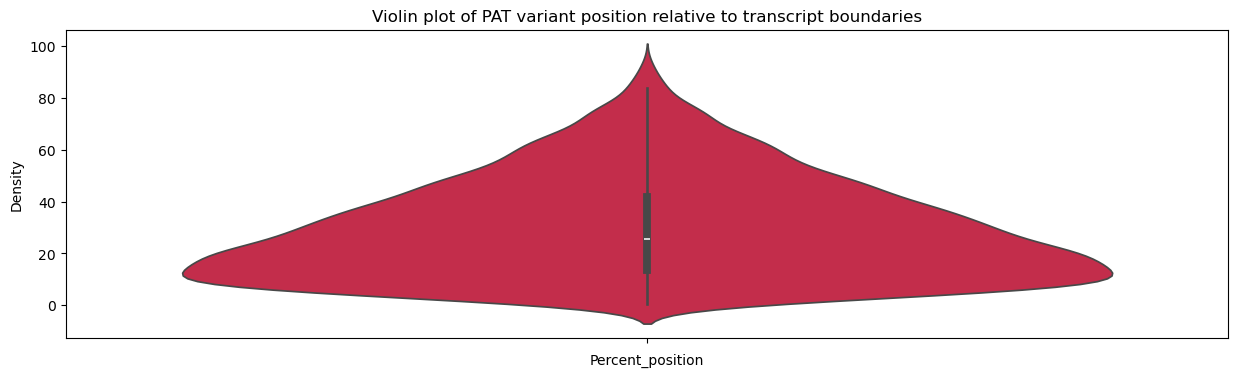

In [35]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=pat_nmd_undergo_final_sorted, color='crimson')
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

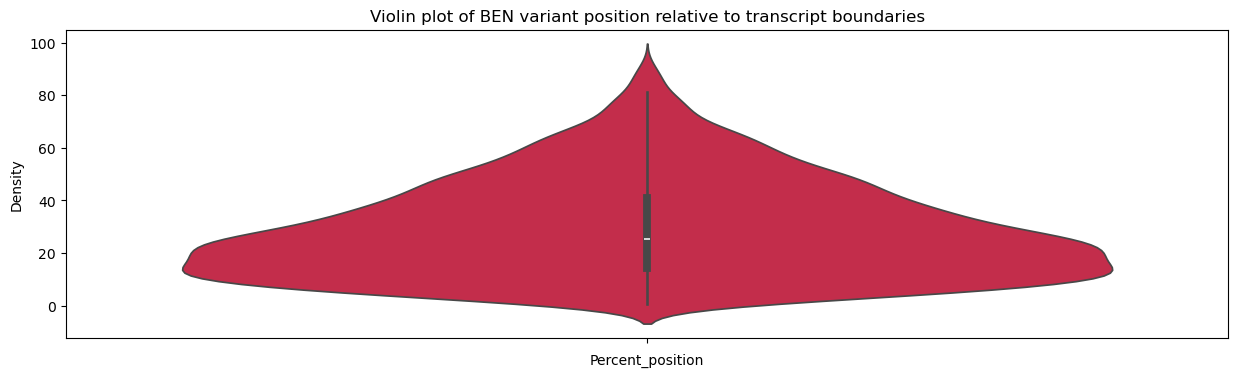

In [36]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=ben_nmd_undergo_final_sorted, color='crimson')
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

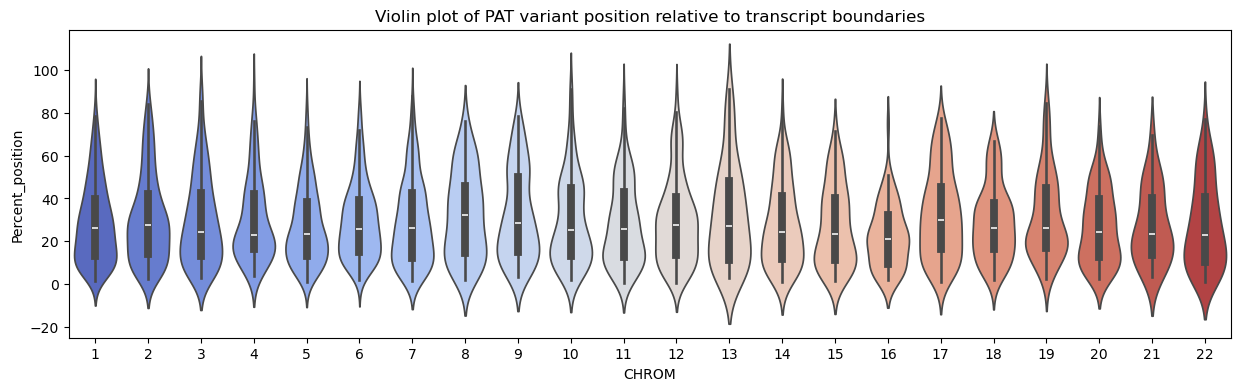

In [37]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=pat_nmd_undergo_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

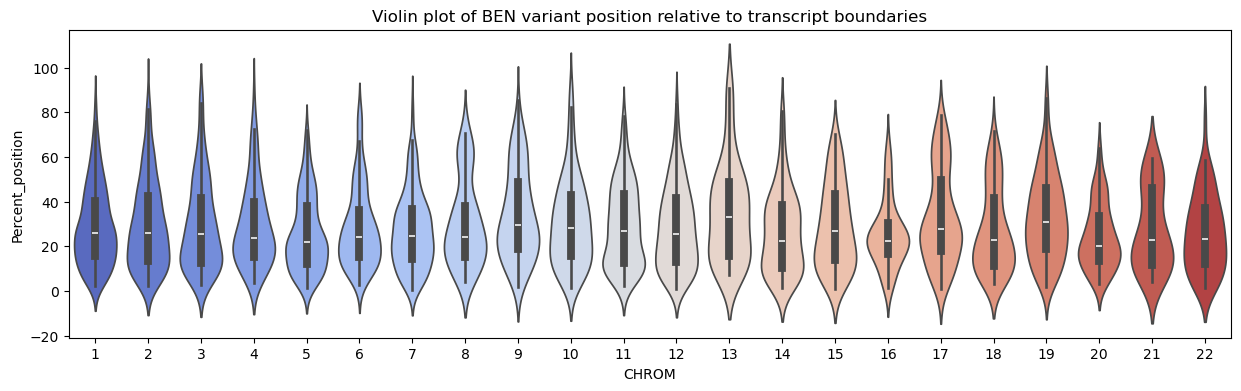

In [38]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=ben_nmd_undergo_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

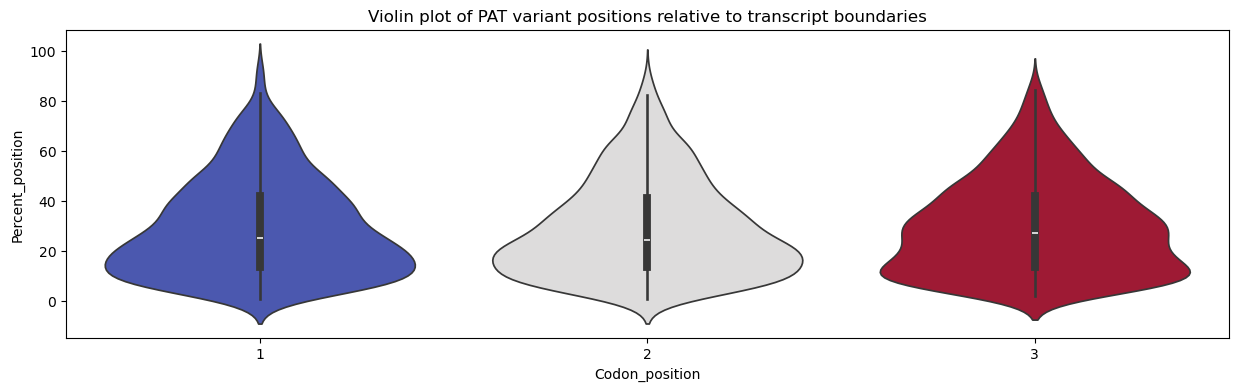

In [39]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=pat_nmd_undergo_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant positions relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

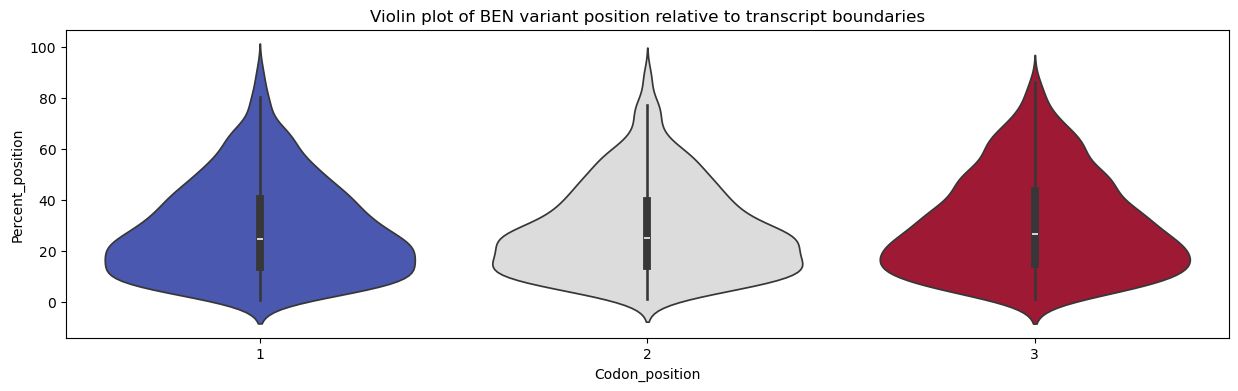

In [40]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=ben_nmd_undergo_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

## 4. Get sequence context

Write the context in the corresponding column of the dataframe.

In [41]:
transcript_fasta = Fasta("data_dir/gencode_data/gencode.v45.transcripts.fa.gz", key_function = lambda x: x.split('.')[0])

Divide dataframes by variant position in a codon.

In [42]:
ben_nmd_undergo_final_1 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 1].copy()
ben_nmd_undergo_final_2 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 2].copy()
ben_nmd_undergo_final_3 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 3].copy()

In [43]:
pat_nmd_undergo_final_1 = pat_nmd_undergo_final.loc[pat_nmd_undergo_final['Codon_position'] == 1].copy()
pat_nmd_undergo_final_2 = pat_nmd_undergo_final.loc[pat_nmd_undergo_final['Codon_position'] == 2].copy()
pat_nmd_undergo_final_3 = pat_nmd_undergo_final.loc[pat_nmd_undergo_final['Codon_position'] == 3].copy()

Get contexts.

In [71]:
get_context(ben_nmd_undergo_final_1, transcript_fasta, 10, 11)
get_context(ben_nmd_undergo_final_2, transcript_fasta, 11, 10)
get_context(ben_nmd_undergo_final_3, transcript_fasta, 12, 9)

'Contexts have been added to the dataframe!'

In [72]:
get_context(pat_nmd_undergo_final_1, transcript_fasta, 10, 11)
get_context(pat_nmd_undergo_final_2, transcript_fasta, 11, 10)
get_context(pat_nmd_undergo_final_3, transcript_fasta, 12, 9)

'Contexts have been added to the dataframe!'

In [76]:
ben_nmd_undergo_final_1.head(10)

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position,Percent_position,Context,AA_context
1264,chr6,7542073,rs1398517175,C,A,HIGH,stop_gained,DSP,ENST00000379802,403,...,NaN,NaN,2.0,0.260,0.999478,NO,1,4.155925,ACCAGAACTCGGACGGCTACT,PSLARTCATR*PAAAGAPAGCTILGAA*SPTRTRTATVKPARCPGT...
2801,chr15,92924449,.,C,A,HIGH,stop_gained,CHD2,ENST00000394196,763,...,NaN,NaN,2.0,0.070,0.787025,NO,1,8.160428,AGAGTCAGTCGGAATCTGAGA,QTQAVSRKVSREVIQEVDMAASRTAALNLLRVSRNLRANQQVPNPS...
1714,chr7,150952811,.,G,A,HIGH,stop_gained,KCNH2,ENST00000262186,1579,...,NaN,NaN,2.0,0.274,0.768429,NO,1,36.789376,TACAAGCTGCAGGCACCGCGC,IIAPKIKERTHNVTEKVTQVLSLGADVLPEYKLQAPRIHRWTILHY...
1711,chr7,150947675,.,C,A,HIGH,stop_gained,KCNH2,ENST00000262186,3304,...,NaN,NaN,2.0,0.274,0.562388,NO,1,76.980429,CCCCCCGGAGAGCCGCCGGGT,SGPSSPESSEDEGPGRSSSPLRLVPFSSPRPPGEPPGGEPLMEDCE...
959,chr4,125451103,.,C,T,HIGH,stop_gained,FAT4,ENST00000394329,11128,...,NaN,NaN,2.0,0.184,0.998962,NO,1,64.882514,ATTCTTGATCGAGAAAAAGAA,DGEVHYLIFGNSRKKGFQINKKTGQIYVSGILDREKEERVSLKVLA...
947,chr4,125317852,.,A,T,HIGH,stop_gained,FAT4,ENST00000394329,2476,...,NaN,NaN,2.0,0.184,0.995855,NO,1,14.436476,CAAGTGTACAGAGTGAACCTG,PGAAVQARSSVASLVIFVNDINDHPPVFSQQVYRVNLSEEAPPGSY...
953,chr4,125408623,rs1734718417,C,T,HIGH,stop_gained,FAT4,ENST00000394329,6784,...,NaN,NaN,3.0,0.184,0.998962,NO,1,39.554545,CTCACTGTTCGAGCAGAAGAT,DEDGIFFLNPITGVFNLTRLLDYEVQQYYILTVRAEDGGGQFTTIR...
950,chr4,125319466,.,C,T,HIGH,stop_gained,FAT4,ENST00000394329,4090,...,NaN,NaN,2.0,0.184,0.995855,NO,1,23.847006,TTTAAAGTACAAGCTTCTGAT,VHDVNDNSPVFDQLSYEVTLSESEPVNSRFFKVQASDKDSGANGEI...
961,chr4,125481622,rs942135672,C,T,HIGH,stop_gained,FAT4,ENST00000394329,13741,...,NaN,NaN,3.0,0.184,0.998962,NO,1,80.117777,CAAAGCTTACGAGGTGCCATG,VTPDTALSLEGKGRLDYHMSQNEKREYLLRQSLRGAMLEPFGVNSL...
952,chr4,125408578,rs1474952333,C,T,HIGH,stop_gained,FAT4,ENST00000394329,6739,...,NaN,NaN,3.0,0.184,0.998962,NO,1,39.292170,AATTTGACTCGATTATTAGAT,DSGVNGEITYIVNEDDEDGIFFLNPITGVFNLTRLLDYEVQQYYIL...


In [77]:
ben_nmd_undergo_final_2.head(10)

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position,Percent_position,Context,AA_context
1766,chr8,60853278,rs549508773,G,T,HIGH,stop_gained,CHD7,ENST00000423902,7070,...,NaN,NaN,4.0,0.076,0.519708,NO,2,60.916767,AGCTGCCAAGGAGAAATGTGA,PDSSSHLICSYSR*EGTGTSRRQSGGA*KPSCQGEM*GQRRGRRNR...
1765,chr8,60836096,.,G,T,HIGH,stop_gained,CHD7,ENST00000423902,4319,...,NaN,NaN,5.0,0.076,0.519708,NO,2,37.213510,AATTTTGGAAGAGTTTAAAGA,SS*RT*PIKHYDGIAEVLQSSVPYQWC*RENFGRV*RNTQCRVSRF...
1929,chr9,132928863,rs753838459,G,A,HIGH,stop_gained,TSC1,ENST00000298552,227,...,NaN,NaN,5.0,0.118,0.882853,NO,2,2.640149,AATGGCCCAACAAGCAAATGT,R*NSLVVAPMKNLQNL*HTSWSQHSAFERENGPTSKCRGASCHAGL...
1681,chr7,128842587,.,G,T,HIGH,stop_gained,FLNC,ENST00000325888,2510,...,NaN,NaN,2.0,0.250,0.999954,NO,2,27.404739,GAACGTGGGCGAGGGCAGCCA,PLLLRAHQAH*AHHHHLLGRRKRAQEPLPGERGRGQPPRAGKGVRP...
1679,chr7,128840055,rs1420159591,C,T,HIGH,stop_gained,FLNC,ENST00000325888,1676,...,NaN,NaN,4.0,0.250,0.999954,NO,2,18.298941,CGCCTCTGGGCGAGGCCTGCA,YRACGLCGCPHHPQSLPCPCVGSL*PQRLPRLWARPAAQGCSRERG...
2802,chr15,92955491,.,T,G,HIGH,stop_gained,CHD2,ENST00000394196,2360,...,NaN,NaN,26.0,0.070,0.744745,NO,2,25.240642,TAACAACATATGAGATCCTCT,FT*VT**AEIRYGNMNGFIPKPKD*SSTHL*QHMRSS*KIRLCWAV...
276,chr1,179990603,rs750564859,C,T,HIGH,stop_gained,CEP350,ENST00000367607,563,...,NaN,NaN,2.0,0.184,0.656119,NO,2,4.197107,AAGTGCTACTCGAAAAATAAG,CSETH*K*IRSSPYKYSCV*FCHGYQEVFYKCYSKNK*KRW*IPG*...
293,chr1,180062310,rs1326776127,C,T,HIGH,stop_gained,CEP350,ENST00000367607,5699,...,NaN,NaN,4.0,0.184,0.628521,NO,2,42.485463,AGAAAAGATCCGACAGACCAC,ARKGRNKTSSRSQ*GSSEGKTADS*TAGGDRKDPTDHHKTTGEIEV...
291,chr1,180053813,.,C,T,HIGH,stop_gained,CEP350,ENST00000367607,5399,...,NaN,NaN,2.0,0.184,0.628521,NO,2,40.248994,GGAGATGGTTCGACAGTATAT,SFSRKNYTVYCQGTEHAILRRTR*LF*IYYGDGSTVYERGRNEGSS...
284,chr1,180011961,rs958142042,C,T,HIGH,stop_gained,CEP350,ENST00000367607,1625,...,NaN,NaN,4.0,0.184,0.628521,NO,2,12.114209,ATCTTCTTGGCGAGATGGACA,ESSQASTKSPKSSTVIKYRMQNR**SSYKYIFLARWTKISKEDSGT...


In [78]:
ben_nmd_undergo_final_3.head(10)

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position,Percent_position,Context,AA_context
1263,chr6,7541928,.,G,T,HIGH,stop_gained,DSP,ENST00000379802,258,...,NaN,NaN,4.0,0.260,0.999478,NO,3,2.660617,TGAGCTGCAACGGAGGCTCCC,RLSLAPSAFSAPARLAYASALSRSPDCPPT*AATEAPTRGSTLWAA...
591,chr2,202552836,.,A,T,HIGH,stop_gained,BMPR2,ENST00000374580,2682,...,NaN,NaN,2.0,0.191,0.988989,NO,3,22.224064,GGGAAAGAAACAAATCTGTGA,RQSKTVGTRMQRLGLLHSVLRKGWLNL**FGKETNL*AQQSIQCLL...
2811,chr16,3791996,rs1224361693,T,A,HIGH,stop_gained,CREBBP,ENST00000262367,2112,...,NaN,NaN,4.0,0.066,0.732415,NO,3,19.573679,ATGCCAGTGACAAGCGAAACC,KLPIVHLHDKSSLIGRTAHDMTVLFASL*KMPVTSETNKPSWGLQL...
277,chr1,179992119,.,C,A,HIGH,stop_gained,CEP350,ENST00000367607,639,...,NaN,NaN,2.0,0.184,0.658878,NO,3,4.763680,ATCCACTAAATCACGAAAAGA,QEVFYKCYSKNK*KRW*IPG*FLG*CSNLQIH*ITKREIS*SSQGH...
287,chr1,180033867,.,C,G,HIGH,stop_gained,CEP350,ENST00000367607,4077,...,NaN,NaN,7.0,0.184,0.628521,NO,3,30.393619,TGTGAGTGTCTCATCAGATAA,EIWDQQQTFC*RF*ADS*YR*HFGGSFWTFCECLIR*GKISENSNF...
289,chr1,180053045,.,C,A,HIGH,stop_gained,CEP350,ENST00000367607,5214,...,NaN,NaN,2.0,0.184,0.637275,NO,3,38.869837,AGAAGAACAATCATTTCGATC,CSISS**KRLNVYCNRIFSEI**IHDRR*NRRTIISIITTFRESPQ...
676,chr3,9447884,rs903969838,G,T,HIGH,stop_gained,SETD5,ENST00000402198,2520,...,NaN,NaN,2.0,0.227,0.559107,NO,3,36.358390,TAACTCCTACTGAAGCTGGAA,PKD*SVRSRPMHSRQNCHKLPWKREEVTV**LLLKLEV*TVQEKTG...
957,chr4,125450808,rs769948581,C,G,HIGH,stop_gained,FAT4,ENST00000394329,10833,...,NaN,NaN,25.0,0.184,0.998962,NO,3,63.162498,AAGCAGAGCTACCATCTTACT,YTVQSSDSDLFVIDPNTGVITTQGFLDFETKQSYHLTVKAFNVPDE...
1384,chr6,78954904,.,C,T,HIGH,stop_gained,PHIP,ENST00000275034,4149,...,NaN,NaN,2.0,0.113,0.929252,NO,3,34.789535,ATTCAAGCATGGAAGAAACAG,KDADVPGTSTRKRKDHQPRRRLRNRAQSYDIQAWKKQCEELLNLIF...
2458,chr12,92851130,.,G,C,HIGH,stop_gained,EEA1,ENST00000322349,1008,...,NaN,NaN,3.0,0.304,0.999846,NO,3,10.244944,AAAATTGCAGTCACAATATGC,KERTGPSSNTNG*HDLGT*ARI*KTQR*MQKIAVTIC*LRGHNKPA...


In [79]:
pat_nmd_undergo_final_1.head(10)

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position,Percent_position,Context,AA_context
13840,chr7,128837185,.,G,A,HIGH,stop_gained,FLNC,ENST00000325888,859,...,NaN,NaN,1.0,0.250,0.999954,NO,1,9.378753,GGAGGCCTGGGACCCCAACCA,AHHQLQP*LAGRQSSGRPGGQLRPRSLPRLGGLGPQPARGERPGGH...
4803,chr15,92924368,.,C,A,HIGH,stop_gained,CHD2,ENST00000394196,682,...,NaN,NaN,1.0,0.070,0.787025,NO,1,7.294118,GCAGTCAGTCGGAAAGTGAGC,IRTKAKRRTVRYTAMHRVTQPLKKLRVQTQAVSRKVSREVIQEVDM...
1055,chr1,179992087,.,G,A,HIGH,stop_gained,CEP350,ENST00000367607,607,...,NaN,NaN,1.0,0.184,0.658878,NO,1,4.525123,TGATTCTTGGGTTAATGCTCC,YSCV*FCHGYQEVFYKCYSKNK*KRW*IPG*FLG*CSNLQIH*ITK...
1060,chr1,179997171,.,T,A,HIGH,stop_gained,CEP350,ENST00000367607,1360,...,NaN,NaN,1.0,0.184,0.628521,NO,1,10.138661,TCCAGCATATAAAGGTTTCAA,AGSY*PSSNGC*C**LSNSKSQKSGNSTTCSSI*RFQPFRDQDSNT...
11374,chr4,125406952,.,G,T,HIGH,stop_gained,FAT4,ENST00000394329,6415,...,NaN,NaN,1.0,0.184,0.998962,NO,1,37.403067,CCAGAATCCGGAGATCTGATA,QLTAMDADEGANALVTYTIISGADDSFRIDPESGDLIATRRLDRER...
11396,chr4,125451040,NaN,C,T,NaN,stop_gained,FAT4,ENST00000394329,11065,...,NaN,NaN,NaN,0.184,0.998962,NO,1,64.515189,GGTAATAGTCGAAAGAAGGGT,EAAPKGTIVGEVFASDRDLGTDGEVHYLIFGNSRKKGFQINKKTGQ...
11402,chr4,125452393,.,C,T,HIGH,stop_gained,FAT4,ENST00000394329,12418,...,NaN,NaN,1.0,0.184,0.998962,NO,1,72.403941,CTTCTCCGGCAGAGTGGAGTA,TFLLAAVKRNHNQYVNPSGVATFFESIKEILLRQSGVKVESVDHDS...
11367,chr4,125318821,.,G,T,HIGH,stop_gained,FAT4,ENST00000394329,3445,...,NaN,NaN,1.0,0.184,0.995855,NO,1,20.086292,GTGGTTTTTGAGAACGTGGCG,LQSPNQAIVTITVLDTQDNPPVFSQVAYSFVVFENVALGYHVGSVS...
11398,chr4,125451424,rs1403984745,C,T,HIGH,stop_gained,FAT4,ENST00000394329,11449,...,NaN,NaN,1.0,0.184,0.998962,NO,1,66.754125,GAATTAGATCGAGAAACCCTT,WSRFSYFIGSGNENGAFSINPQTGQITVTAELDRETLPIYNLSVLA...
11360,chr4,125317363,NaN,C,T,NaN,stop_gained,FAT4,ENST00000394329,1987,...,NaN,NaN,NaN,0.184,0.995855,NO,1,11.585330,GCTCGGCGCCAATACTCGCTT,IRYRLQDEGTPFQMDPETGLITVREPLDFEARRQYSLTVQAMDRGV...


In [80]:
pat_nmd_undergo_final_2.head(10)

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position,Percent_position,Context,AA_context
14402,chr8,60852186,NaN,C,T,NaN,stop_gained,CHD7,ENST00000423902,6350,...,NaN,NaN,NaN,0.076,0.519708,NO,2,54.713079,ACGGCGGCCTCGAGAGGAAGT,TSAPAHYCLSAQL*KATDEARGPNED*PAQTAASRGSESSGSGKGS...
14375,chr8,60841997,NaN,C,T,NaN,stop_gained,CHD7,ENST00000423902,5312,...,NaN,NaN,NaN,0.076,0.519708,NO,2,45.769430,GGATAAGTCACAGGGCTATGC,QCSEGR*ADGVLRLGK*F*RKALCKATASPG*VTGLCKE*MFQGGE...
15290,chr9,132907364,NaN,T,A,NaN,stop_gained,TSC1,ENST00000298552,1487,...,NaN,NaN,NaN,0.118,0.787313,NO,2,17.294720,GAAGGAAGAGAGAATGGATTC,PSNLSSSSPTLSFG*LRAHFTPPGHSHTPQEGRENGFCKTMSTQTT...
12514,chr6,7562675,NaN,G,A,NaN,stop_gained,DSP,ENST00000379802,866,...,NaN,NaN,NaN,0.260,0.999478,NO,2,8.930597,TGGTGGCCTGGGGTGTGGACC,VRVALAGMSSPNMSPVNVWGG*GSKGRRWTWWPGVWTWPQWSSTLT...
13930,chr7,128854777,NaN,G,T,NaN,stop_gained&splice_region_variant,FLNC,ENST00000325888,7232,...,NaN,NaN,NaN,0.250,0.999954,NO,2,78.960585,CGTGCCAGCCGAGTTCAGCAT,PLSVHCGAAG*RWCPQGAGRRHRAGARCGRRASRVQHLDPGGWRWG...
1052,chr1,179990579,.,A,T,HIGH,stop_gained,CEP350,ENST00000367607,539,...,NaN,NaN,1.0,0.184,0.656119,NO,2,4.018190,CATGGATACCAAGAAGTCTTC,GCTFSNQGCSETH*K*IRSSPYKYSCV*FCHGYQEVFYKCYSKNK*...
1057,chr1,179996755,.,C,T,HIGH,stop_gained,CEP350,ENST00000367607,944,...,NaN,NaN,1.0,0.184,0.631281,NO,2,7.037424,TTTAAATGATCGACCAGCAAT,DDRQSRRTEYTEL*F*ELPIICHQ*YSC*VFK*STSN*CIAKF*MF...
1100,chr1,180084149,.,C,T,HIGH,stop_gained,CEP350,ENST00000367607,6602,...,NaN,NaN,1.0,0.184,0.637977,NO,2,49.217236,ACTGAAAGCCCAAGAAGCCAG,*DQSSEG*VAEKKISCEPAEEGTEKKAKGKTESPRSQSDQAVRVI*...
1068,chr1,180015900,.,C,T,HIGH,stop_gained,CEP350,ENST00000367607,2450,...,NaN,NaN,1.0,0.184,0.628521,NO,2,18.264500,AAACAAAGTACAGGAACGTCC,DLA*RAISSTCYAGNTGQTRVSAIWRI*QRKQSTGTSPKCIFQ**H...
1064,chr1,180014107,.,C,T,HIGH,stop_gained,CEP350,ENST00000367607,2000,...,NaN,NaN,1.0,0.184,0.628521,NO,2,14.909796,TGTAGAGTTACAGAACCAGAA,LK*GLFTY*NSWHS**PTAGFYSSHCKARYCRVTEPEVISTSTCS*...


In [81]:
pat_nmd_undergo_final_3.head(10)

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position,Percent_position,Context,AA_context
12568,chr6,7571949,NaN,G,T,NaN,stop_gained,DSP,ENST00000379802,2256,...,NaN,NaN,NaN,0.260,0.999478,NO,3,23.264927,GGATGCTGATGGAGCTGCAGA,QLKSLIMEPAKMSTIIK*LKPTEKMTSKKHGC*WSCRRFAGR*STA...
8768,chr2,202514899,NaN,C,T,NaN,stop_gained,BMPR2,ENST00000374580,1689,...,NaN,NaN,NaN,0.191,0.988989,NO,3,13.995691,GAGACCGTAAACAAGGTCTTC,EMRQ*SLLWHQSLY*LF**LPYALDTEC*QETVNKVFTV*T*WRQQ...
4876,chr15,93009298,NaN,C,T,NaN,stop_gained,CHD2,ENST00000394196,5139,...,NaN,NaN,NaN,0.070,0.747695,NO,3,54.962567,CCTACTCAGATCAGGAGCACA,LTRGSTCKNSWNTPGTAC*KSETG*PSALKPTQIRSTSNSGGGTYG...
4924,chr16,3757901,NaN,G,A,NaN,stop_gained,CREBBP,ENST00000262367,4314,...,NaN,NaN,NaN,0.066,0.751332,NO,3,39.981464,GCAAGACATCCCGAGTCTATA,SGSWTQGNTKSPGSTWTTSGSCSTMPGSIIARHPESISFAVSLQRS...
1102,chr1,180090734,.,G,A,HIGH,stop_gained,CEP350,ENST00000367607,6792,...,NaN,NaN,1.0,0.184,0.637977,NO,3,50.633666,GGCAAAGAATTGGAAATCACT,TNSQASD*NALLSF*KTQDQTPHTTTQI*NGKELEITNRVRTFQRI...
1108,chr1,180093304,.,C,A,HIGH,stop_gained,CEP350,ENST00000367607,7545,...,NaN,NaN,1.0,0.184,0.637977,NO,3,56.247204,TTTTGAGGTGTCATCTTTGCT,SFCS*RDTIL*RF*SVFFQERNFS*IVQR*F*GVIFAVTQERLSVL...
1109,chr1,180094072,.,C,G,HIGH,stop_gained,CEP350,ENST00000367607,8313,...,NaN,NaN,1.0,0.184,0.931839,NO,3,61.972566,CCAGCAGTCTTCAGTGGATTC,YRSLS**K*KP*NRNRQCTGHFWGT*SPCSPAVFSGFTDFFKGKQR...
1099,chr1,180080632,.,C,A,HIGH,stop_gained,CEP350,ENST00000367607,6441,...,NaN,NaN,1.0,0.184,0.651348,NO,3,48.016997,TTATAGTTGGTCAGATGAGTC,LHICVKAGV*QRKS*DWRTMSPAYQVPSALL*LVR*VIIYDTVRNY...
1065,chr1,180014123,.,C,A,HIGH,stop_gained,CEP350,ENST00000367607,2016,...,NaN,NaN,1.0,0.184,0.628521,NO,3,15.029074,CCAGAAGTCATCAGCACCAGT,FTY*NSWHS**PTAGFYSSHCKARYCRVTEPEVISTSTCS*ESQPS...
1086,chr1,180043084,.,C,G,HIGH,stop_gained,CEP350,ENST00000367607,4737,...,NaN,NaN,1.0,0.184,0.637275,NO,3,35.313851,AACTCATATCTCAGATGCTGT,NV*NSSSAVRNCSPHHRRSTSNL*DGRVD*NSYLRCCRGFRSSPCN...


## 5. Build a sequence logo

In [46]:
filtered_context_ben_1 = filter_and_convert_to_list(ben_nmd_undergo_final_1['Context'])
filtered_context_ben_2 = filter_and_convert_to_list(ben_nmd_undergo_final_2['Context'])
filtered_context_ben_3 = filter_and_convert_to_list(ben_nmd_undergo_final_3['Context'])

In [47]:
filtered_context_pat_1 = filter_and_convert_to_list(pat_nmd_undergo_final_1['Context'])
filtered_context_pat_2 = filter_and_convert_to_list(pat_nmd_undergo_final_2['Context'])
filtered_context_pat_3 = filter_and_convert_to_list(pat_nmd_undergo_final_3['Context'])

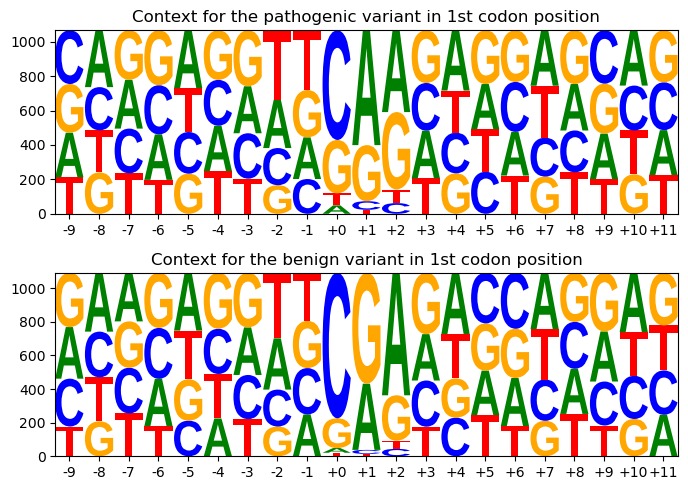

In [48]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_context_pat_1)
counts_mat_ben_1 = lm.alignment_to_matrix(filtered_context_ben_1)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_1, font_name='Liberation Sans', ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-9, 12))
pat_logo.ax.set_title('Context for the pathogenic variant in 1st codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_1, font_name='Liberation Sans', ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-9, 12))
ben_logo.ax.set_title('Context for the benign variant in 1st codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/1st_pos_context_nmd_undergo.png', bbox_inches='tight')

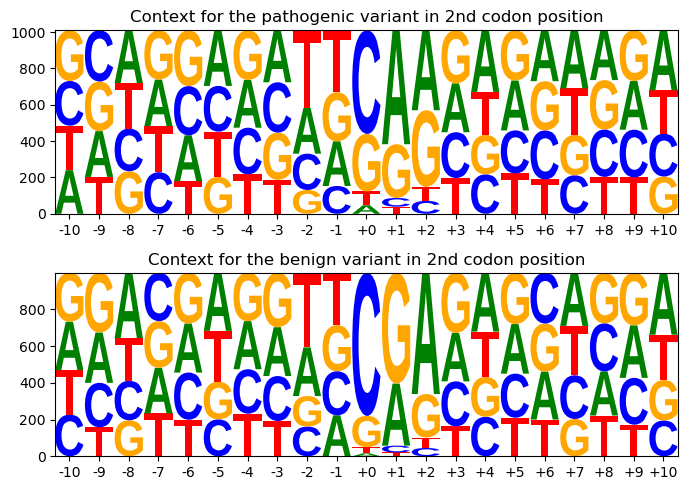

In [49]:
counts_mat_pat_2 = lm.alignment_to_matrix(filtered_context_pat_2)
counts_mat_ben_2 = lm.alignment_to_matrix(filtered_context_ben_2)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_2, font_name='Liberation Sans', ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-10, 11))
pat_logo.ax.set_title('Context for the pathogenic variant in 2nd codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_2, font_name='Liberation Sans', ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-10, 11))
ben_logo.ax.set_title('Context for the benign variant in 2nd codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/2nd_pos_context_nmd_undergo.png', bbox_inches='tight')

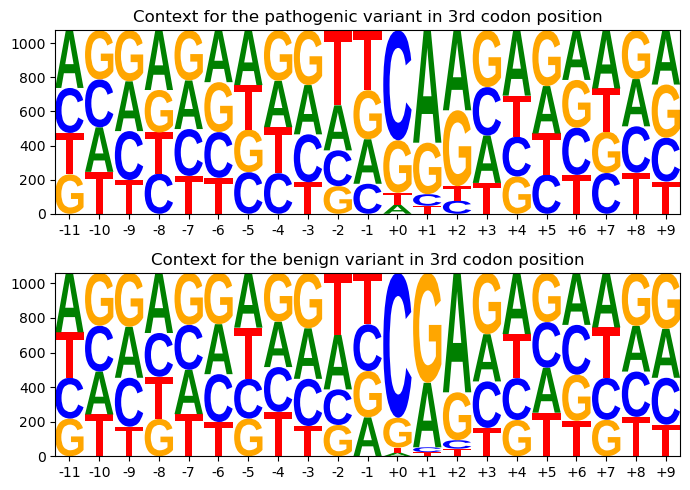

In [50]:
counts_mat_pat_3 = lm.alignment_to_matrix(filtered_context_pat_3)
counts_mat_ben_3 = lm.alignment_to_matrix(filtered_context_ben_3)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_3, font_name='Liberation Sans', ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-11, 10))
pat_logo.ax.set_title('Context for the pathogenic variant in 3rd codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_3, font_name='Liberation Sans', ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-11, 10))
ben_logo.ax.set_title('Context for the benign variant in 3rd codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/3rd_pos_context_nmd_undergo.png', bbox_inches='tight')

## 6. Statistical comparison of positions in contexts

Calculate chi-squares for each position when comparing two matrices (for pathogenic and benign contexts).

In [51]:
chi2_values_1, p_values_1 = calculate_chi2_p_values(filtered_context_ben_1, filtered_context_pat_1)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values_1, p_values_1)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 9:
        print("==="*25)
    if counter == 10:
        print("==="*25)

Position 0: Chi-square = 10.769451459409602, p-value = 0.013040153620770137
Position 1: Chi-square = 3.9745054637794204, p-value = 0.26423027159187035
Position 2: Chi-square = 1.0324501681746985, p-value = 0.7934006441992937
Position 3: Chi-square = 1.7579662321494738, p-value = 0.6241243855052059
Position 4: Chi-square = 4.364401815242769, p-value = 0.22470895115986142
Position 5: Chi-square = 6.639184994555578, p-value = 0.08433208019419237
Position 6: Chi-square = 0.5485802676016687, p-value = 0.9080960117968525
Position 7: Chi-square = 1.272448529931823, p-value = 0.7356856084081185
Position 8: Chi-square = 17.18821052160071, p-value = 0.0006464614127961924
Position 9: Chi-square = 103.02685719721221, p-value = 3.4719473593611453e-22
Position 10: Chi-square = 194.42336236609646, p-value = 6.761364439328839e-42
Position 11: Chi-square = 108.37504997786806, p-value = 2.454793192331955e-23
Position 12: Chi-square = 7.240653104711965, p-value = 0.0646103250194712
Position 13: Chi-squar

In [52]:
chi2_values_2, p_values_2 = calculate_chi2_p_values(filtered_context_ben_2, filtered_context_pat_2)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values_2, p_values_2)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 10:
        print("==="*25)
    if counter == 11:
        print("==="*25)

Position 0: Chi-square = 2.1744791297722132, p-value = 0.5369926643995282
Position 1: Chi-square = 14.044936710362864, p-value = 0.002844619934626102
Position 2: Chi-square = 11.406950514186637, p-value = 0.00971708996093364
Position 3: Chi-square = 3.7894818047634717, p-value = 0.28511194607412155
Position 4: Chi-square = 3.394579552184844, p-value = 0.33469436986220624
Position 5: Chi-square = 7.342782940519157, p-value = 0.06173865497607456
Position 6: Chi-square = 1.0802907324594448, p-value = 0.7818339827856778
Position 7: Chi-square = 5.023143439476289, p-value = 0.1701102909351893
Position 8: Chi-square = 8.909865189955891, p-value = 0.030513595099924934
Position 9: Chi-square = 26.030508105523417, p-value = 9.398154576951898e-06
Position 10: Chi-square = 107.98528520833212, p-value = 2.977713893427312e-23
Position 11: Chi-square = 198.1570975057606, p-value = 1.055244732489656e-42
Position 12: Chi-square = 104.69032005624518, p-value = 1.5232447102412765e-22
Position 13: Chi-sq

In [53]:
chi2_values_3, p_values_3 = calculate_chi2_p_values(filtered_context_ben_3, filtered_context_pat_3)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values_3, p_values_3)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 11:
        print("==="*25)
    if counter == 12:
        print("==="*25)

Position 0: Chi-square = 2.682536119100355, p-value = 0.4432032608416273
Position 1: Chi-square = 1.2739044525455667, p-value = 0.7353388508873173
Position 2: Chi-square = 2.1904280073447016, p-value = 0.5338362153732183
Position 3: Chi-square = 2.9146868387997276, p-value = 0.4049666839013071
Position 4: Chi-square = 2.990928522276734, p-value = 0.3930259353886708
Position 5: Chi-square = 0.8631268141977024, p-value = 0.8343157819793247
Position 6: Chi-square = 4.720841339158749, p-value = 0.1934175409361893
Position 7: Chi-square = 1.5819456835666772, p-value = 0.6634904080682353
Position 8: Chi-square = 0.3035189444932674, p-value = 0.9593653089340225
Position 9: Chi-square = 13.69006875379359, p-value = 0.0033588654113083675
Position 10: Chi-square = 27.422010814007955, p-value = 4.802039342219632e-06
Position 11: Chi-square = 93.72410834803429, p-value = 3.471330444590396e-20
Position 12: Chi-square = 222.21235872833452, p-value = 6.675210262262976e-48
Position 13: Chi-square = 10

In [54]:
positions_1, positions_2, positions_3 = list(range(-9, 12)), list(range(-10, 11)), list(range(-11, 10))

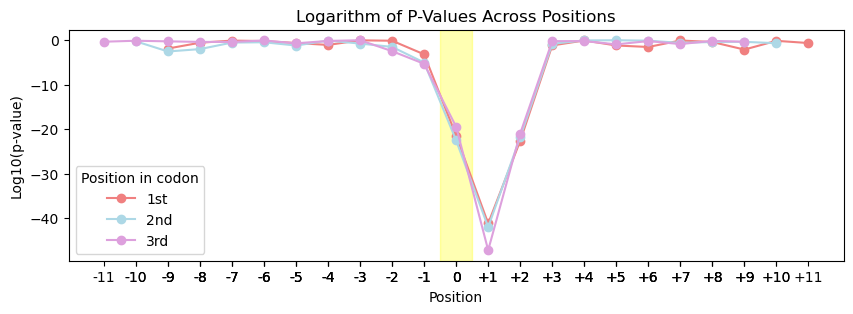

In [55]:
positions_list = [positions_1, positions_2, positions_3]
p_values_list = [p_values_1, p_values_2, p_values_3]

plot_p_values(positions_list, p_values_list)

# plt.savefig('images/p_values_nmd_undergo_plot.png')
# plt.show()

### Посмотрим на аминокислоты в округе

Краткий пример, что сделала по аминокислотам. Надо будет ещё навести красоту, но как будто бы какая-то фигня вышла всё равно.

In [56]:
transcript_fasta['ENST00000398473'][2209 - 10 : 2209 + 11]  # CAG  5|7 (1 позиция)

>ENST00000398473:2200-2220
ATCAGGGAACAGAGACGCCAG

In [57]:
my_rna = Seq("ATCAGGGAACAGAGACGCCAG")
my_aa = my_rna.translate()
my_aa

Seq('IREQRRQ')

In [58]:
# здесь просто добавила по 90 букв к каждой границе, чтобы вывести в итоге равное количество аминокислот 
# вне зависимости от позиции варианта в кодоне

get_context(ben_nmd_undergo_final_1, transcript_fasta, 10+90, 11+90)
get_context(ben_nmd_undergo_final_2, transcript_fasta, 11+90, 10+90)
get_context(ben_nmd_undergo_final_3, transcript_fasta, 12+90, 9+90)

get_context(pat_nmd_undergo_final_1, transcript_fasta, 10+90, 11+90)
get_context(pat_nmd_undergo_final_2, transcript_fasta, 11+90, 10+90)
get_context(pat_nmd_undergo_final_3, transcript_fasta, 12+90, 9+90)

'Contexts have been added to the dataframe!'

Для аминокислотного контекста я пыталась выровнять количество аминокислот вокруг целевого кодона, учитывая при этом, что у нас датафреймы разделены по позиции. Получилось равное количество остатков для всех датафреймов (67).

**Позиция в кодоне 1:**  

**33 позиция на лого**

In [59]:
pat_nmd_undergo_final_1['AA_context'] = translate_context(pat_nmd_undergo_final_1['Context'])
ben_nmd_undergo_final_1['AA_context'] = translate_context(ben_nmd_undergo_final_1['Context'])

In [60]:
filtered_aa_context_pat_1 = filter_and_convert_to_list(pat_nmd_undergo_final_1['AA_context'])
filtered_aa_context_ben_1 = filter_and_convert_to_list(ben_nmd_undergo_final_1['AA_context'])

Text(0.5, 1.0, 'Benign context')

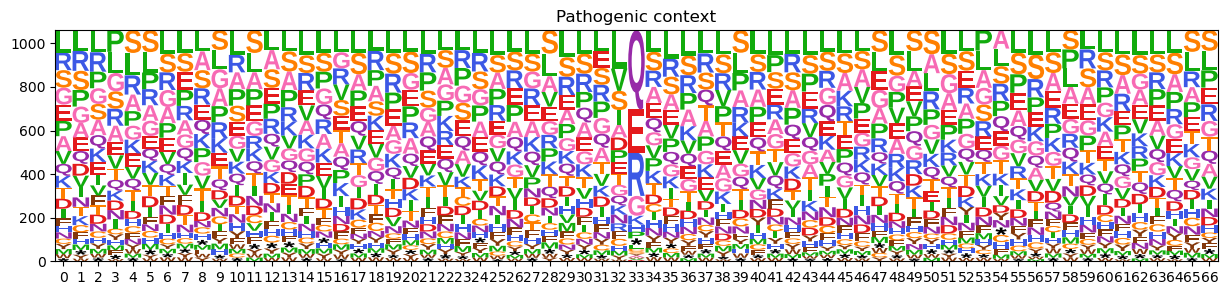

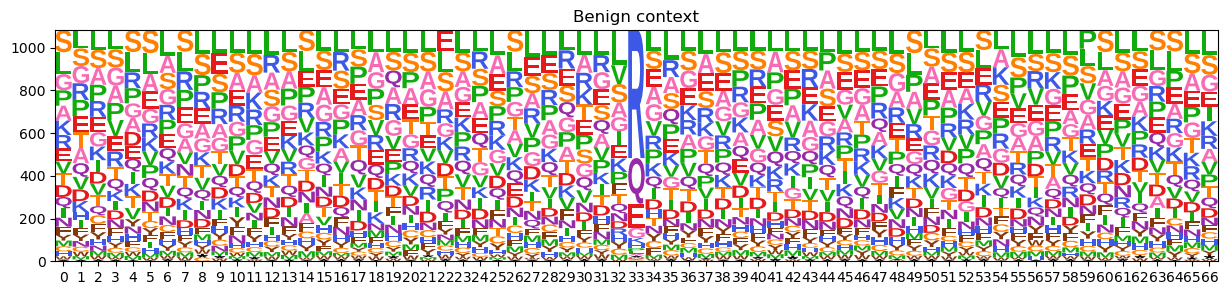

In [61]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_aa_context_pat_1)
pat_logo = lm.Logo(counts_mat_pat_1, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
pat_logo.style_xticks()
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_1 = lm.alignment_to_matrix(filtered_aa_context_ben_1)
ben_logo = lm.Logo(counts_mat_ben_1, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')

**Позиция в кодоне 2:**  
  
**33 позиция на лого**

In [62]:
pat_nmd_undergo_final_2['AA_context'] = translate_context(pat_nmd_undergo_final_2['Context'])
ben_nmd_undergo_final_2['AA_context'] = translate_context(ben_nmd_undergo_final_2['Context'])

In [63]:
filtered_aa_context_pat_2 = filter_and_convert_to_list(pat_nmd_undergo_final_2['AA_context'])
filtered_aa_context_ben_2 = filter_and_convert_to_list(ben_nmd_undergo_final_2['AA_context'])

Text(0.5, 1.0, 'Benign context')

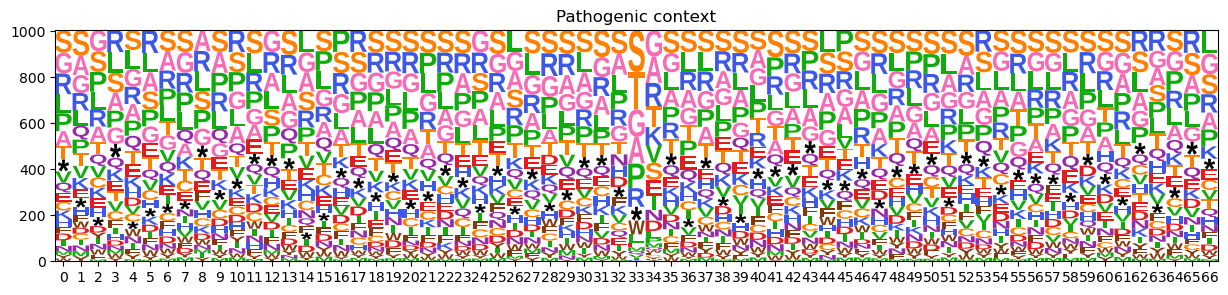

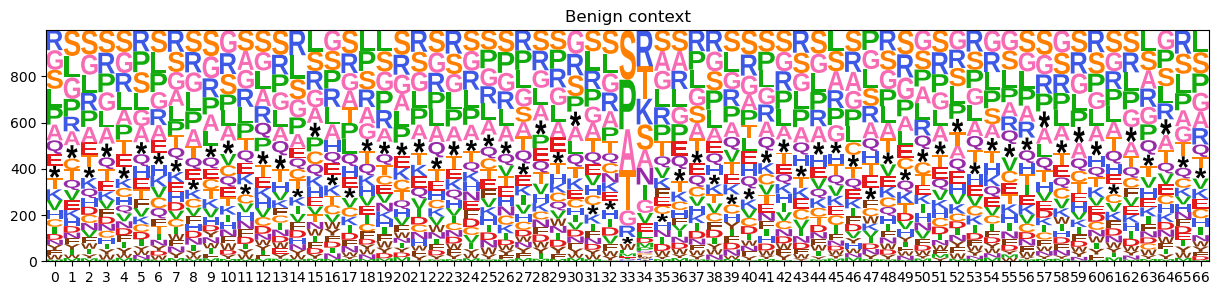

In [64]:
counts_mat_pat_2 = lm.alignment_to_matrix(filtered_aa_context_pat_2)
pat_logo = lm.Logo(counts_mat_pat_2, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
pat_logo.style_xticks()
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_2 = lm.alignment_to_matrix(filtered_aa_context_ben_2)
ben_logo = lm.Logo(counts_mat_ben_2, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')

**Позиция в кодоне 3:**

**Я в замешательстве -- здесь бОльшие изменения видны не на 33 позиции, как должно быть, а на 34 -_-**

In [65]:
pat_nmd_undergo_final_3['AA_context'] = translate_context(pat_nmd_undergo_final_3['Context'])
ben_nmd_undergo_final_3['AA_context'] = translate_context(ben_nmd_undergo_final_3['Context'])

In [66]:
filtered_aa_context_pat_3 = filter_and_convert_to_list(pat_nmd_undergo_final_3['AA_context'])
filtered_aa_context_ben_3 = filter_and_convert_to_list(ben_nmd_undergo_final_3['AA_context'])

Text(0.5, 1.0, 'Benign context')

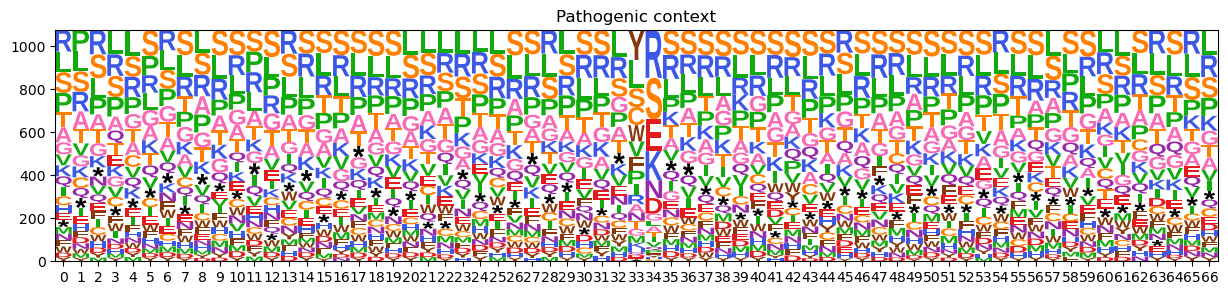

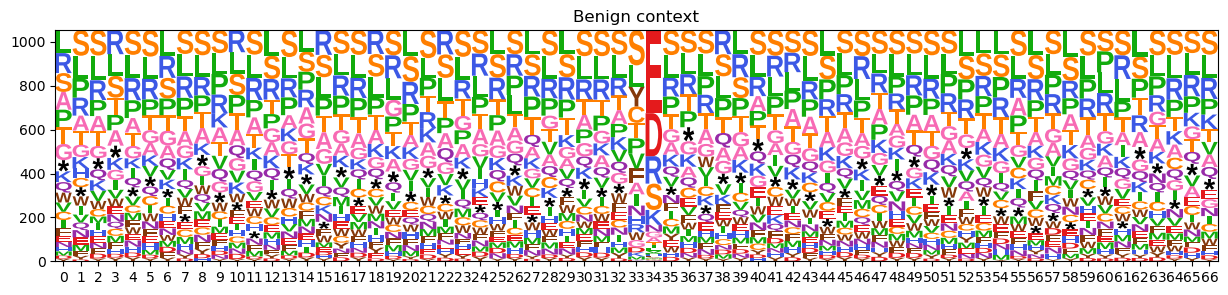

In [67]:
counts_mat_pat_3 = lm.alignment_to_matrix(filtered_aa_context_pat_3)
pat_logo = lm.Logo(counts_mat_pat_3, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
pat_logo.style_xticks()
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_3 = lm.alignment_to_matrix(filtered_aa_context_ben_3)
ben_logo = lm.Logo(counts_mat_ben_3, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')

**Дальше я попробовала сконкатенировать датафреймы, но в итоге вышло не очень красиво и понятно:**

In [68]:
pat_concatenated_df = pd.concat([pat_nmd_undergo_final_1, pat_nmd_undergo_final_2, pat_nmd_undergo_final_3])
ben_concatenated_df = pd.concat([ben_nmd_undergo_final_1, ben_nmd_undergo_final_2, ben_nmd_undergo_final_3])

In [69]:
filtered_aa_context_pat = filter_and_convert_to_list(pat_concatenated_df['AA_context'])
filtered_aa_context_ben = filter_and_convert_to_list(ben_concatenated_df['AA_context'])

In [ ]:
counts_mat_pat = lm.alignment_to_matrix(filtered_aa_context_pat)
pat_logo = lm.Logo(counts_mat_pat, 
                   figsize=(15, 2),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
pat_logo.style_xticks()
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben = lm.alignment_to_matrix(filtered_aa_context_ben)
ben_logo = lm.Logo(counts_mat_ben, 
                   figsize=(15, 2),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')